In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import csv
from sklearn.preprocessing import StandardScaler

import datetime
import cartopy.crs as ccrs
import cftime

import utils

In [2]:
# Takes in a file of data and searches for row headers (i.e. the rows that correspond to a unique hurricane).
# Returns the data as a dataframe, with the row header ID as the first column.
def clean_file(filename):
    
    f = open(filename, mode='r')
    reader = csv.reader(f)
    header = []
    data = [] # 2d list to hold all the data
    for row in reader:
        if row[0].startswith("AL"): # Header row
            header = row[0]
        else:
            row.insert(0, header)# append ID to row
            data.append(row[:-1]) # don't know why theres an extra empty column
    f.close()
    df = pd.DataFrame(data, columns=['ID','Date', 'Time', 'Record', 'Status', 'Latitude', 'Longitude',
                               'Wind speed','Pressure','34NE','34SE','34SW','34NW',
                               '50NE','50SE','50SW','50NW','64NE','64SE','64SW','64NW'])
    df['Date'] = df['Date'].apply(utils.convert_time)
    
    df['Latitude'] = df['Latitude'].apply(utils.convert_coords)
    df['Longitude'] = df['Longitude'].apply(utils.convert_coords)
    return df

In [3]:
'''
Takes in a pandas dataframe of hurricane data and:
(1) Change the record identifier column into 1 if hurricane made Landfall (L), else 0
(2) adjust the date column into 3 separate columns - month, day, year. Drops date column.
(3) Imputes missing values with the mean of the column of the truncated data
(4) Standardize data for columns of continuous variables
'''

def prep_hurricane_data(df):
    
    # change record identifier (1)
    df['Record'] = pd.Series(df['Record'] == ' L', dtype=int)
    #df['Status'] = df['Status'].map({' TD':0,' TS':1,' HU':2,' EX':3,' SD':4,' SS':5,' LO':6,' WV':7,' DB':8})
    df.drop('ID', axis = 1, inplace = True)
    df.drop('Status', axis = 1, inplace = True) # this column doesn't have much useful info for our goals, its just used to categorize hurricane type
    
    
    
    # create new columns identify by the date (2)
    df['Year'] = df['Date'].apply(lambda x: x[0:4]).astype(int)
    df['Month'] = df['Date'].apply(lambda x: x[4:6]).astype(int)
    df['Day'] = df['Date'].apply(lambda x: x[6:8]).astype(int)
    df.drop('Date', axis = 1, inplace = True)

    
    # imputes missing values with mean of column of truncated data (3)
    for column in df:
        if column not in ['Latitude', 'Longitude']:
            df[column] = pd.to_numeric(df[column]) # turn every column (except lat/long) into numeric data type
        df[column].replace(-999, np.nan, inplace=True)
        if df[column].isnull().values.any():  # check for columns with nan values
            df[column].fillna(df[column].mean(skipna=True), inplace=True)  # replace all NaNs with mean of column

    return df

In [4]:
df = clean_file('hurdat2.txt')
# df = prep_hurricane_data(df)
df

,ID,Date,Time,Record,Status,Latitude,Longitude,Wind speed,Pressure,34NE,...,34SW,34NW,50NE,50SE,50SW,50NW,64NE,64SE,64SW,64NW
0,AL011851,1851-06-25 00:00:00,0000,,HU,28.0,-94.8,80,-999,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
1,AL011851,1851-06-25 00:00:00,0600,,HU,28.0,-95.4,80,-999,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
2,AL011851,1851-06-25 00:00:00,1200,,HU,28.0,-96.0,80,-999,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
3,AL011851,1851-06-25 00:00:00,1800,,HU,28.1,-96.5,80,-999,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
4,AL011851,1851-06-25 00:00:00,2100,L,HU,28.2,-96.8,80,-999,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51835,AL202019,2019-11-26 00:00:00,1200,,EX,52.2,-9.3,45,970,90,...,120,90,0,0,0,0,0,0,0,0
51836,AL202019,2019-11-26 00:00:00,1800,,EX,52.2,-8.9,40,972,90,...,90,90,0,0,0,0,0,0,0,0
51837,AL202019,2019-11-27 00:00:00,0000,,EX,51.8,-8.2,40,974,0,...,90,0,0,0,0,0,0,0,0,0
51838,AL202019,2019-11-27 00:00:00,0600,,EX,51.4,-6.0,40,976,0,...,90,0,0,0,0,0,0,0,0,0


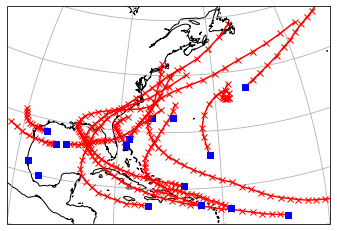

In [5]:
hurricane_IDs = df['ID'].unique()
ax = utils.create_geoaxes()

for ID in hurricane_IDs[0:20]:
    utils.plot_hurricane_trajectory(df, ID, ax=ax)

## Part 1: Predicting whether or not a hurricane will make landfall

Since the records in our hurricane dataset contain *timestamps* of specific hurricanes, it will be more useful to create a dataframe which contains key features of each individual hurricane's track. However, 

In [6]:
# Create dataframe of each individual hurricane
hurricane_IDs = df['ID'].unique()
hurricane_df = pd.DataFrame.from_dict({'ID':hurricane_IDs})
columns = ['Duration', 'Initial latitude', 'Initial longitude',
           'Makes landfall', 'Landfall latitude', 'Landfall longitude']
hurricane_df = hurricane_df.set_index(['ID'])

# Set hurricane data columns
for col in columns:
    hurricane_df[col] = None

for ID in hurricane_IDs:
    attrs = utils.get_hurricane_attributes(df, ID)
    for col in attrs:
        hurricane_df.at[ID, col] = attrs[col]
hurricane_df

,Duration,Initial latitude,Initial longitude,Makes landfall,Landfall latitude,Landfall longitude
ID,,,,,,
AL011851,14,28,-94.8,1,28.2,-96.8
AL021851,1,22.2,-97.6,0,NaN,NaN
AL031851,1,12,-60,0,NaN,NaN
AL041851,49,13.4,-48,1,30.1,-85.7
AL051851,16,32.5,-73.5,0,NaN,NaN
...,...,...,...,...,...,...
AL162019,15,22.2,-95.7,0,NaN,NaN
AL172019,10,24.7,-94.8,0,NaN,NaN
AL182019,22,40,-38.3,0,NaN,NaN


What percent of hurricanes actually make landfall?

In [7]:
sum(hurricane_df['Makes landfall'])/len(hurricane_df)

0.34231378763866877

So, we see that roughly a third of all atlantic tropical cyclones make landfall. But the code below shows that the probability of landfall strongly depends on the genesis coordinate of the cyclone. This is because, not only are more westerly coordinates simply closer to land and thus likelier to be hit, but also due to the different dynamical regimes that partition the Atlantic ocean.

In [8]:
lons = np.arange(-90, -10, 10)
for i in range(len(lons) - 1):
    lonW = lons[i]
    lonE = lons[i+1]
    subset = hurricane_df[(hurricane_df['Initial longitude'] >= lonW) & (hurricane_df['Initial longitude'] < lonE)]
    pct_landfalling = sum(subset['Makes landfall'])/len(subset)
    print('Percent of cyclones starting between longitudes', lonW, 'and', lonE, 'making landfall:',
          '{:.3}'.format(pct_landfalling))

Percent of cyclones starting between longitudes -90 and -80 making landfall: 0.564
Percent of cyclones starting between longitudes -80 and -70 making landfall: 0.374
Percent of cyclones starting between longitudes -70 and -60 making landfall: 0.242
Percent of cyclones starting between longitudes -60 and -50 making landfall: 0.266
Percent of cyclones starting between longitudes -50 and -40 making landfall: 0.158
Percent of cyclones starting between longitudes -40 and -30 making landfall: 0.138
Percent of cyclones starting between longitudes -30 and -20 making landfall: 0.148


In [9]:
lats = np.arange(0, 50, 10)
for i in range(len(lats) - 1):
    latS = lats[i]
    latN = lats[i+1]
    subset = hurricane_df[(hurricane_df['Initial latitude'] >= latS) & (hurricane_df['Initial latitude'] < latN)]
    pct_landfalling = sum(subset['Makes landfall'])/len(subset)
    print('Percent of cyclones starting between longitudes', latS, 'and', latN, 'making landfall:',
          '{:.3}'.format(pct_landfalling))

Percent of cyclones starting between longitudes 0 and 10 making landfall: 0.312
Percent of cyclones starting between longitudes 10 and 20 making landfall: 0.346
Percent of cyclones starting between longitudes 20 and 30 making landfall: 0.405
Percent of cyclones starting between longitudes 30 and 40 making landfall: 0.131


To better categorize the dynamical regimes where the cyclones start, we use k-means clustering on the initial coordinates.

In [10]:
k = 3
p = 2

from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=k, p=p)
neigh.fit(hurricane_df[['Initial latitude', 'Initial longitude']])

neigh

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                 radius=1.0)

In [11]:
neigh.kneighbors(hurricane_df[['Initial latitude', 'Initial longitude']].iloc[0:10])

(array([[0.        , 0.53851648, 0.72801099],
        [0.        , 0.28284271, 0.4       ],
        [0.        , 0.        , 0.31622777],
        [0.        , 0.3       , 0.4472136 ],
        [0.        , 0.        , 0.28284271],
        [0.        , 0.1       , 0.53851648],
        [0.        , 0.53851648, 0.70710678],
        [0.        , 0.92195445, 1.39283883],
        [0.        , 0.41231056, 0.5       ],
        [0.        , 0.2236068 , 0.36055513]]), array([[   0, 1573, 1690],
        [   1, 1794, 1850],
        [  12,    2,  278],
        [   3,  545, 1414],
        [   4,   37, 1674],
        [   5, 1381,   64],
        [   6,  395,  233],
        [   7, 1577,  109],
        [   8, 1238,  141],
        [   9,  356,  759]], dtype=int64))

In [12]:
samples = [[0., 0., 0.], [0., .5, 0.], [1., 1., .5], [1, 1, 1], [.2, .5, .2]]
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=1)
neigh.fit(samples)

print(neigh.kneighbors([[1., 1., 1.]]))

(array([[0.]]), array([[3]], dtype=int64))


# Correlation matrix

In [13]:
def hurr_quadrants(df):
    df.drop(['ID','Date', 'Time', 'Record', 'Status', 'Latitude', 'Longitude', 'Wind speed','Pressure'],
            1, inplace=True)
    for column in df:
        df[column] = pd.to_numeric(df[column])
        df[column].replace([-999, 0], np.nan, inplace=True)
    return df

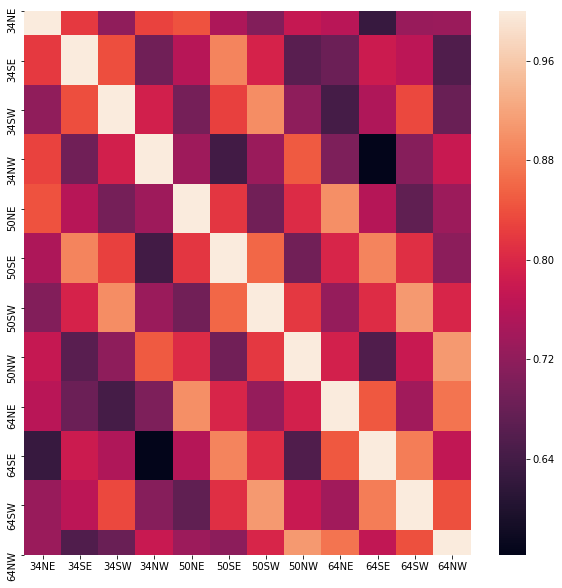

In [14]:
import seaborn as sns

df1 = clean_file('hurdat2.txt')
df_q = hurr_quadrants(df1)
corr = df_q.corr()

plt.figure(figsize=(10,10))  
sns.heatmap(corr, xticklabels=corr.columns,yticklabels=corr.columns)

# Hurricane Genesis Points

In [42]:
genesis_df = df.groupby('ID').first()  # get the starting (genesis) row of each unique hurricane
BBox = (genesis_df.Longitude.min(),   genesis_df.Longitude.max(),      
         genesis_df.Latitude.min(), genesis_df.Latitude.max())  # define a bounding box that includes all genesis data

Date          1893
Time          1893
Record        1893
Status        1893
Latitude      1893
Longitude     1893
Wind speed    1893
Pressure      1893
34NE          1893
34SE          1893
34SW          1893
34NW          1893
50NE          1893
50SE          1893
50SW          1893
50NW          1893
64NE          1893
64SE          1893
64SW          1893
64NW          1893
dtype: int64

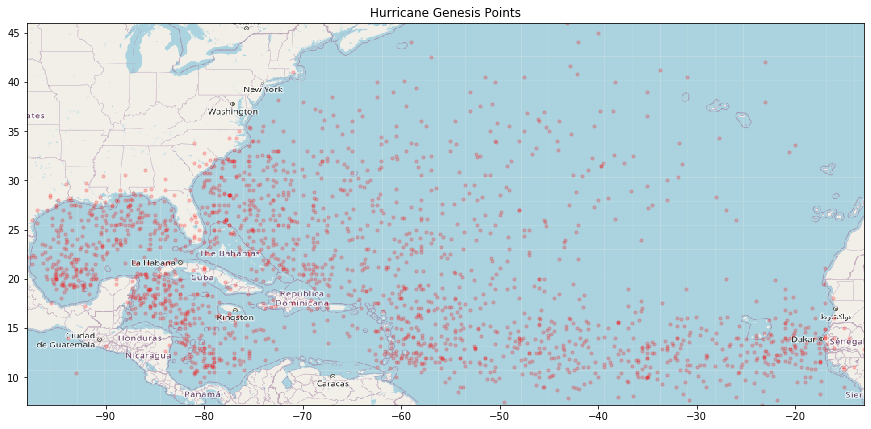

In [43]:
map_overlay = plt.imread('map.png')

fig, ax = plt.subplots(figsize = (15,12))
ax.scatter(genesis_df.Longitude, genesis_df.Latitude, zorder=1, alpha= 0.2, c='r', s=10)
ax.set_title('Hurricane Genesis Points')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.imshow(map_overlay, zorder=0, extent = BBox, aspect= 'equal')

Some hurricanes are recorded as 'forming over land,' which is possible but the chances are slim to none. Hurricanes can technically form anywhere where there is a warm body of water/lots of moisture. Hurricanes that do form over land typically do not grow very big or last very long. Interesting to note that nearly all the hurricanes that have been recorded as 'forming over land' are from the earlier records (pre 1900s), according to the data. This could be perhaps due to lack of equipment/technologies to accurately record the data (For example, the lat/long data was recorded to the nearest tenth of a degree, which can cover a rather large distance).

# Linear Regression

In [19]:
# Takes in a file of data and searches for row headers (i.e. the rows that correspond to a unique hurricane).
# Returns the data as a dataframe, with the row header ID as the first column.
def clean_file2(filename):
    
    f = open(filename, mode='r')
    reader = csv.reader(f)
    header = []
    data = [] # 2d list to hold all the data
    for row in reader:
        if row[0].startswith("AL"): # Header row
            header = row[0]
        else:
            row.insert(0, header)# append ID to row
            data.append(row[:-1]) # don't know why theres an extra empty column
    f.close()
    df = pd.DataFrame(data, columns=['ID','Date', 'Time', 'Record', 'Status', 'Latitude', 'Longitude',
                               'Wind speed','Pressure','34NE','34SE','34SW','34NW',
                               '50NE','50SE','50SW','50NW','64NE','64SE','64SW','64NW'])
    return df

In [20]:
'''
Takes in a pandas dataframe of hurricane data and:
(1) Change the record identifier column into 1 if hurricane made Landfall (L), else 0
(2) adjust the date column into 3 separate columns - month, day, year. Drops date column.
(3) Imputes missing values with the mean of the column of the truncated data
(4) Standardize data for columns of continuous variables
'''
def prep_hurricane_data2(df):
    
    # change record identifier (1)
    df['Record'] = pd.Series(df['Record'] == ' L', dtype=int)
    #df['Status'] = df['Status'].map({' TD':0,' TS':1,' HU':2,' EX':3,' SD':4,' SS':5,' LO':6,' WV':7,' DB':8})
    #df.drop('ID', axis = 1, inplace = True)
    df.drop('Status', axis = 1, inplace = True) # this column doesn't have much useful info for our goals, its just used to categorize hurricane type
    
    
    # create new columns identify by the date (2)
    df['Year'] = df['Date'].apply(lambda x: x[0:4]).astype(int)
    df['Month'] = df['Date'].apply(lambda x: x[4:6]).astype(int)
    df['Day'] = df['Date'].apply(lambda x: x[6:8]).astype(int)
    df.drop('Date', axis = 1, inplace = True)
    
    # Strip characters (N, E, S, W) from lat/long
    #df['Latitude'] = df['Latitude'].map(lambda x: x.rstrip('NS'))
    #df['Longitude'] = df['Longitude'].map(lambda x: x.rstrip('EW'))
    df['Latitude'] = df.apply(lambda row: float(row.Latitude.rstrip('N')) if ('N' in row.Latitude) 
                              else float(row.Latitude.rstrip('S'))*-1, axis = 1)
    df['Longitude'] = df.apply(lambda row: float(row.Longitude.rstrip('E')) if ('E' in row.Longitude) 
                              else float(row.Longitude.rstrip('W'))*-1, axis = 1)
    # imputes missing values with mean of column of truncated data (3)
    for column in df:
        if column not in ['ID']:
            df[column] = pd.to_numeric(df[column]) # turn every column into numeric data type
        df[column].replace(-999, np.nan, inplace=True)
        if df[column].isnull().values.any():  # check for columns with nan values
            df[column].fillna(df[column].mean(skipna=True), inplace=True)  # replace all NaNs with mean of column
            
    
    # standardize the variables (4)
#     tv_temp1 = df['Latitude'] # temporary variable for target variables
#     tv_temp2 = df['Longitude']
#     tv_temp3 = df['ID']
#     scaler = StandardScaler()
#     scaler.fit(df.drop(['Latitude','Longitude','ID'], axis=1))
#     df = pd.DataFrame(scaler.transform(df.drop(['Latitude','Longitude','ID'], axis=1)), 
#                       columns = df.drop(['Latitude','Longitude','ID'], axis=1).columns)
#     df['Latitude'] = tv_temp1
#     df['Longitude'] = tv_temp2
#     df['ID'] = tv_temp3
    return df

In [21]:
df1 = clean_file2('hurdat2.txt')
df1 = prep_hurricane_data2(df1)
df1

,ID,Time,Record,Latitude,Longitude,Wind speed,Pressure,34NE,34SE,34SW,...,50SE,50SW,50NW,64NE,64SE,64SW,64NW,Year,Month,Day
0,AL011851,0,0,28.0,-94.8,80,992.119732,83.199075,77.627768,50.983816,...,23.816622,16.460818,19.488318,8.15101,7.75432,5.549404,6.532611,1851,6,25
1,AL011851,600,0,28.0,-95.4,80,992.119732,83.199075,77.627768,50.983816,...,23.816622,16.460818,19.488318,8.15101,7.75432,5.549404,6.532611,1851,6,25
2,AL011851,1200,0,28.0,-96.0,80,992.119732,83.199075,77.627768,50.983816,...,23.816622,16.460818,19.488318,8.15101,7.75432,5.549404,6.532611,1851,6,25
3,AL011851,1800,0,28.1,-96.5,80,992.119732,83.199075,77.627768,50.983816,...,23.816622,16.460818,19.488318,8.15101,7.75432,5.549404,6.532611,1851,6,25
4,AL011851,2100,1,28.2,-96.8,80,992.119732,83.199075,77.627768,50.983816,...,23.816622,16.460818,19.488318,8.15101,7.75432,5.549404,6.532611,1851,6,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51835,AL202019,1200,0,52.2,-9.3,45,970.000000,90.000000,240.000000,120.000000,...,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,2019,11,26
51836,AL202019,1800,0,52.2,-8.9,40,972.000000,90.000000,240.000000,90.000000,...,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,2019,11,26
51837,AL202019,0,0,51.8,-8.2,40,974.000000,0.000000,210.000000,90.000000,...,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,2019,11,27
51838,AL202019,600,0,51.4,-6.0,40,976.000000,0.000000,180.000000,90.000000,...,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,2019,11,27


In [35]:
'''
Same as above prep_hurricane_data but drop ID
'''
def prep_hurricane_data2(df):
    
    # change record identifier (1)
    df['Record'] = pd.Series(df['Record'] == ' L', dtype=int)
    #df['Status'] = df['Status'].map({' TD':0,' TS':1,' HU':2,' EX':3,' SD':4,' SS':5,' LO':6,' WV':7,' DB':8})
    df.drop('ID', axis = 1, inplace = True)
    df.drop('Status', axis = 1, inplace = True) # this column doesn't have much useful info for our goals, its just used to categorize hurricane type
    
    
    # create new columns identify by the date (2)
    df['Year'] = df['Date'].apply(lambda x: x[0:4]).astype(int)
    df['Month'] = df['Date'].apply(lambda x: x[4:6]).astype(int)
    df['Day'] = df['Date'].apply(lambda x: x[6:8]).astype(int)
    df.drop('Date', axis = 1, inplace = True)
    
    # Strip characters (N, E, S, W) from lat/long
    #df['Latitude'] = df['Latitude'].map(lambda x: x.rstrip('NS'))
    #df['Longitude'] = df['Longitude'].map(lambda x: x.rstrip('EW'))
    df['Latitude'] = df.apply(lambda row: float(row.Latitude.rstrip('N')) if ('N' in row.Latitude) 
                              else float(row.Latitude.rstrip('S'))*-1, axis = 1)
    df['Longitude'] = df.apply(lambda row: float(row.Longitude.rstrip('E')) if ('E' in row.Longitude) 
                              else float(row.Longitude.rstrip('W'))*-1, axis = 1)
    # imputes missing values with mean of column of truncated data (3)
    for column in df:
        if column not in ['ID']:
            df[column] = pd.to_numeric(df[column]) # turn every column into numeric data type
        df[column].replace(-999, np.nan, inplace=True)
        if df[column].isnull().values.any():  # check for columns with nan values
            df[column].fillna(df[column].mean(skipna=True), inplace=True)  # replace all NaNs with mean of column
            
    
    # standardize the variables (4)
#     tv_temp1 = df['Latitude'] # temporary variable for target variables
#     tv_temp2 = df['Longitude']
#     scaler = StandardScaler()
#     scaler.fit(df.drop(['Latitude','Longitude'], axis=1))
#     df = pd.DataFrame(scaler.transform(df.drop(['Latitude','Longitude'], axis=1)), 
#                       columns = df.drop(['Latitude','Longitude'], axis=1).columns)
#     df['Latitude'] = tv_temp1
#     df['Longitude'] = tv_temp2
    return df

In [36]:
df1 = clean_file2('hurdat2.txt')
df2 = prep_hurricane_data2(df1)
df2

,Time,Record,Latitude,Longitude,Wind speed,Pressure,34NE,34SE,34SW,34NW,...,50SE,50SW,50NW,64NE,64SE,64SW,64NW,Year,Month,Day
0,0,0,28.0,-94.8,80,992.119732,83.199075,77.627768,50.983816,61.755293,...,23.816622,16.460818,19.488318,8.15101,7.75432,5.549404,6.532611,1851,6,25
1,600,0,28.0,-95.4,80,992.119732,83.199075,77.627768,50.983816,61.755293,...,23.816622,16.460818,19.488318,8.15101,7.75432,5.549404,6.532611,1851,6,25
2,1200,0,28.0,-96.0,80,992.119732,83.199075,77.627768,50.983816,61.755293,...,23.816622,16.460818,19.488318,8.15101,7.75432,5.549404,6.532611,1851,6,25
3,1800,0,28.1,-96.5,80,992.119732,83.199075,77.627768,50.983816,61.755293,...,23.816622,16.460818,19.488318,8.15101,7.75432,5.549404,6.532611,1851,6,25
4,2100,1,28.2,-96.8,80,992.119732,83.199075,77.627768,50.983816,61.755293,...,23.816622,16.460818,19.488318,8.15101,7.75432,5.549404,6.532611,1851,6,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51835,1200,0,52.2,-9.3,45,970.000000,90.000000,240.000000,120.000000,90.000000,...,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,2019,11,26
51836,1800,0,52.2,-8.9,40,972.000000,90.000000,240.000000,90.000000,90.000000,...,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,2019,11,26
51837,0,0,51.8,-8.2,40,974.000000,0.000000,210.000000,90.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,2019,11,27
51838,600,0,51.4,-6.0,40,976.000000,0.000000,180.000000,90.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,2019,11,27


In [31]:
#landfall_df = df2.loc[df2['Record'] == 1] # hurricanes that made landfall
#landfall_df

,ID,Time,Record,Latitude,Longitude,Wind speed,Pressure,34NE,34SE,34SW,...,50SE,50SW,50NW,64NE,64SE,64SW,64NW,Year,Month,Day
4,AL011851,2100,1,28.2,-96.8,80,992.119732,83.199075,77.627768,50.983816,...,23.816622,16.460818,19.488318,8.15101,7.75432,5.549404,6.532611,1851,6,25
48,AL041851,2100,1,30.1,-85.7,100,992.119732,83.199075,77.627768,50.983816,...,23.816622,16.460818,19.488318,8.15101,7.75432,5.549404,6.532611,1851,8,23
96,AL061851,1500,1,41.1,-71.7,50,992.119732,83.199075,77.627768,50.983816,...,23.816622,16.460818,19.488318,8.15101,7.75432,5.549404,6.532611,1851,10,19
127,AL011852,600,1,30.2,-88.6,100,961.000000,83.199075,77.627768,50.983816,...,23.816622,16.460818,19.488318,8.15101,7.75432,5.549404,6.532611,1852,8,26
163,AL031852,0,1,28.0,-82.8,70,992.119732,83.199075,77.627768,50.983816,...,23.816622,16.460818,19.488318,8.15101,7.75432,5.549404,6.532611,1852,9,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51468,AL052019,1230,1,35.2,-75.6,85,956.000000,190.000000,190.000000,150.000000,...,120.000000,80.000000,70.000000,50.00000,60.00000,50.000000,40.000000,2019,9,6
51499,AL072019,1530,1,24.2,-97.7,40,1003.000000,0.000000,0.000000,40.000000,...,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,2019,9,4
51618,AL112019,1745,1,28.9,-95.4,40,1003.000000,0.000000,40.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,2019,9,17
51637,AL122019,2200,1,18.1,-65.4,40,1004.000000,0.000000,70.000000,30.000000,...,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,2019,9,24


In [25]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [37]:
# LR on latitude target variable
target = 'Latitude'

X = df2.drop(target, 1)
Y = df2[target]

X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=.75)

In [41]:
reg = LinearRegression()
reg.fit(X_train, y_train)

lat_pred = reg.predict(X_test)
print('Mean squared error: %.2f'% mean_squared_error(y_test, lat_pred)) #0 is perfect score
print('Coefficient of determination: %.2f'% r2_score(y_test, lat_pred)) #1 is perfect score
print(y_test)
print(lat_pred)

Mean squared error: 97.82
Coefficient of determination: 0.06
19319    32.2
4435     55.7
13469    25.7
8102     20.6
34106    25.7
         ... 
21070    28.2
20825    27.8
32071    27.2
19909    39.7
9895     27.0
Name: Latitude, Length: 12960, dtype: float64
[26.81505103 31.00630452 26.95840781 ... 26.00607389 27.58335895
 26.27191468]


In [39]:
# LR on latitude target variable
target = 'Longitude'

X = df2.drop(target, 1)
Y = df2[target]

X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=.75)

In [40]:
reg = LinearRegression()
reg.fit(X_train, y_train)

lat_pred = reg.predict(X_test)
print('Mean squared error: %.2f'% mean_squared_error(y_test, lat_pred)) #0 is perfect score
print('Coefficient of determination: %.2f'% r2_score(y_test, lat_pred)) #1 is perfect score

Mean squared error: 97.82
Coefficient of determination: 0.06
